In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
plt.style.use('seaborn')

In [2]:
class Regressor:
    
    def __init__(self,
                 label,
                 l_rate = .5,
                 stop = 1e-3,
                 reg_rate = 0.,
                 beta = .5,
                 epochs = 1000,
                 logistic=True,
                ):
        
        self.label = label
        self.l_rate = l_rate
        self.stop = stop
        self.reg_rate = reg_rate
        self.beta = beta
        self.epochs = epochs
        self.logistic = logistic
        
#---------------------------------------------------------------------------------------------------------------------------       
                   
    def matrix(self, dataset):
        
        X = dataset.drop(self.label, axis=1).to_numpy()
        X = np.insert(X, 0, 1, axis=1)
        y = dataset[[self.label]].to_numpy()

        return X, y   
    
#----------------------------------------------------------------------------------------------------------------------------
 
    def split(self, dataset, cutoff = .8):
        
        n = len(dataset)
        
        df_train, df_test = dataset.iloc[0:int(n*cutoff)], dataset.iloc[int(n*cutoff):]
        
        X_train, y_train = Regressor.matrix(self, df_train)
        X_test, y_test = Regressor.matrix(self, df_test)
          
        return  X_train, y_train, X_test, y_test
    
#---------------------------------------------------------------------------------------------------------------------------    
    
    def fit(self, X, y, graph = False):
        
        n = len(X)
        
        np.random.seed(3479)
        weights = np.random.rand(1, X.shape[1])
    
        Gamma = np.full((1, X.shape[1]), self.reg_rate/n)
        Gamma[0, 0] = 0
    
        W_list = [weights]
        for i in range(self.epochs):
            H = (1 / (1 + np.exp(-X @ weights.T))) if self.logistic else (X @ weights.T)
 
            dJ = (1/n) * ((H-y).T @ X)
            update = weights - (self.l_rate * dJ)

            soft_thresholding = lambda W, K: np.sign(W) * np.maximum(abs(W)-K, 0)
            shrinkage = 1 / (1 + 2*self.l_rate*(1-self.beta)*Gamma)
            weights_ = shrinkage * soft_thresholding(update, self.l_rate*self.beta*Gamma) 
            
            W_list.append(weights_)
        
            delta = weights - weights_
            weights = weights_
        
            if (abs(delta) <= self.stop).all():
                break
        else:
            print('max epochs reached')
    
        W_list = np.array(W_list) 
        
        setattr(Regressor, 'weights', weights)
  
        if graph:
            plt.figure(figsize=(15, 10))
            for i in range(W_list.shape[2]):
                plt.plot(W_list[...,i], label=f'W_{i}')
            plt.legend(ncol=3, frameon=True, loc='upper right')
            plt.title('PARAMETERS\' EVOLUTION', fontsize=15)
            plt.xlabel('epochs', fontsize=13)
            plt.ylabel('parameters\' values', fontsize=13)
            plt.show()

        return self
    
#---------------------------------------------------------------------------------------------------------------------------    
    
    def predict(self, X):
        
        output = 1 / (1 + np.exp(-X @ self.weights.T))
        setattr(Regressor, 'prediction', output)
        
        return self
    
#---------------------------------------------------------------------------------------------------------------------------    
    
    def fit_predict(self, X_train, y_train, X_test, graph=False):
        
        weights = Regressor.fit(self, X_train, y_train, graph)
        setattr(Regressor, 'weights', weights)
        
        output = 1 / (1 + np.exp(-X_test @ self.weights.T))
        setattr(Regressor, 'prediction', output)
        
        return output, weights
    
#---------------------------------------------------------------------------------------------------------------------------    
    
    def metrics(self, test, threshold = 0.5, verbose = True):
        
        classification = np.array((self.prediction >= threshold), dtype=np.int)
    
        TP = len(classification[(classification == 1) & (classification == test)])
        FP = len(classification[(classification == 1) & (classification != test)])
        TN = len(classification[(classification == 0) & (classification == test)])
        FN = len(classification[(classification == 0) & (classification != test)])

        epsilon = 1e-10 
        a = (TP+TN) / (TP+TN+FP+FN)
        p = TP / (TP+FP+epsilon)
        r = TP / (TP+FN+epsilon)
        F1 = (2*p*r) / (p+r+epsilon) 

        confusion_matrix = np.array([[TP, FP], [TN, FN]])
        setattr(Regressor, 'confusion_matrix', confusion_matrix)
    
        if verbose:
            print(f'Accuracy: {a}\nPrecision: {p}\nRecall: {r}\nF1 score: {F1}\n\nConfusion Matrix:\n {confusion_matrix}')
    
        return confusion_matrix
    
#---------------------------------------------------------------------------------------------------------------------------

    def ROC(self, test):
        
        results = (Regressor.metrics(self, test, i, False).reshape(4) for i in np.arange(0.0, 1.1, 0.001))
        TP, FP, TN, FN = zip(*results)
    
        epsilon = 1e-7
        TPR = np.array(TP) / (np.array(TP) + np.array(FN) + epsilon)
        FPR = np.array(FP) / (np.array(FP) + np.array(TN) + epsilon)
    
        AUC = np.around(np.trapz(TPR, FPR), 2)
    
        plt.figure(figsize=(8, 8))
        plt.plot(FPR, TPR, color='b')
        plt.plot([0,1], [0,1], 'r--')
        plt.text(0.7, 0.2, f'AUC = {abs(AUC)}', fontsize=16, color='k')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('ROC', fontsize=15)
        plt.show()
        
#---------------------------------------------------------------------------------------------------------------------------       
        
    def cross_val(self, dataset, folds = 10, threshold = 0.5,):
        
        dataset = dataset.sample(frac=1)
        
        slices= np.arange(0, len(dataset), len(dataset)//folds)
        results = np.zeros((2, 2), dtype=np.int)
        for i in range(folds):
            df_train = dataset.drop(range(slices[i], slices[i+1]))
            df_test = dataset.iloc[slices[i]:slices[i+1]]
        
            X_train, Y_train = Regressor.matrix(self, df_train)
            X_test, Y_test = Regressor.matrix(self, df_test)
        
            output = Regressor.fit(self, X_train, Y_train).predict(X_test)
            results += Regressor.metrics(self, Y_test, threshold, False)
        
        (TP, FP), (TN, FN) = results
    
        epsilon = 1e-7
        a = (TP+TN) / (TP+TN+FP+FN)
        p = TP / (TP+FP+epsilon)
        r = TP / (TP+FN+epsilon)
        F1 = (2*p*r) / (p+r)
    
        confusion_matrix = np.array([[TP, FP], [TN, FN]])
    
        print(f'Accuracy: {a}\nPrecision: {p}\nRecall: {r}\nF1 score: {F1}\n\nConfusion Matrix:\n {confusion_matrix}')
            


In [3]:
df = pd.read_csv(
    "C:\\Users\\wince\\Google Drive\\DATA SCIENCE\\LEZIONI\\ML\\Polignano\\01.REGRESSION\\DataEx_LinRegression\\heart.arff.csv",
    delimiter=',')

In [4]:
df.shape

(303, 14)

In [5]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [6]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


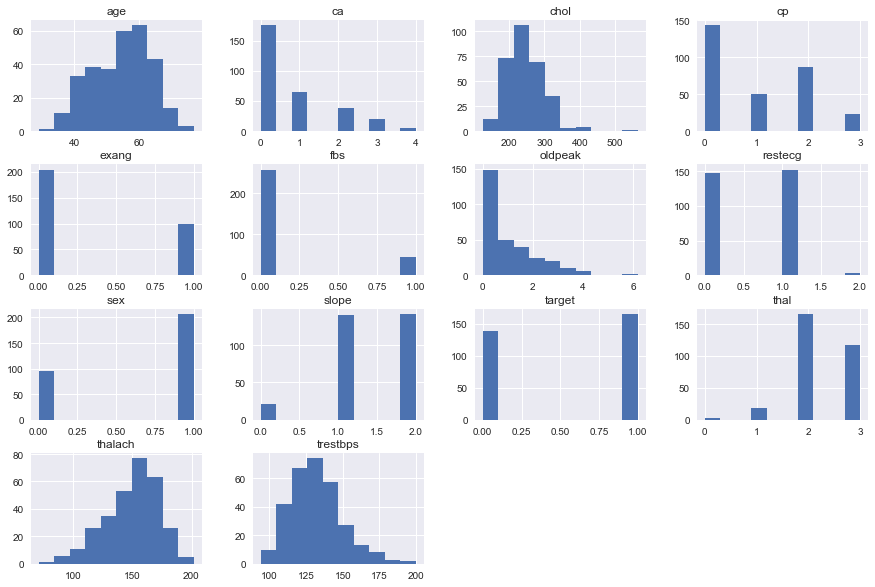

In [7]:
ax = df.hist(bins=10, figsize=(15, 10))

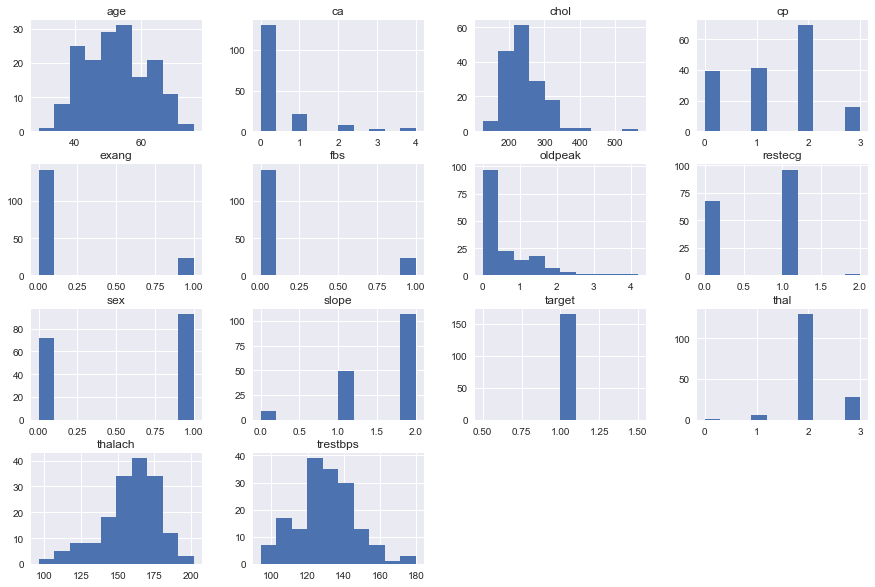

In [8]:
ax = df.query('target == 1').hist(bins=10, figsize=(15, 10))

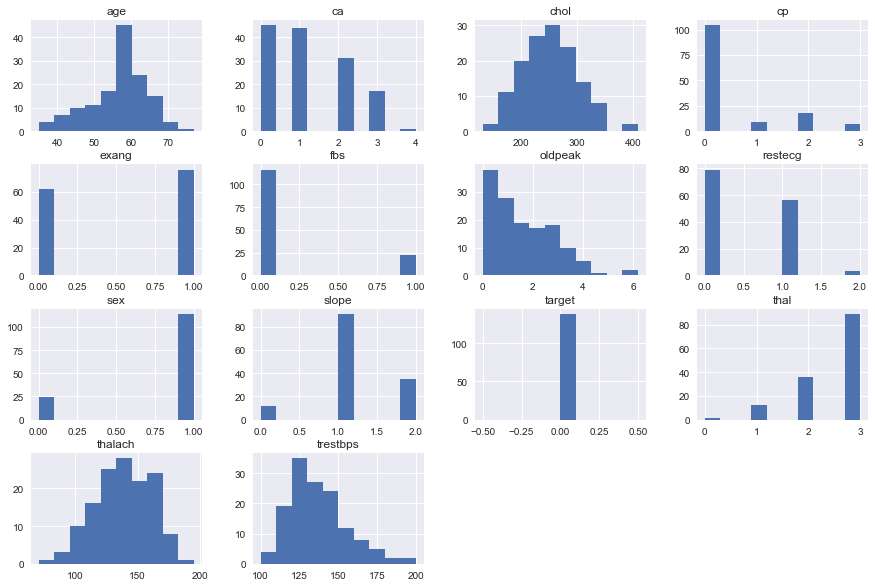

In [9]:
ax = df.query('target == 0').hist(bins=10, figsize=(15, 10))

In [10]:
df.groupby(['sex']).count().target

sex
0     96
1    207
Name: target, dtype: int64

In [11]:
df.groupby(['exang']).count().target

exang
0    204
1     99
Name: target, dtype: int64

In [12]:
num_columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
#ord_columns = ['cp', 'restecg', 'slope', 'thal', 'ca']
ord_columns = []
cat_columns = [col for col in df.columns if col not in (num_columns + ord_columns)]
cat_columns

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']

In [13]:
df[cat_columns] = df[cat_columns].astype('category')

In [14]:
df[num_columns] = df[num_columns].transform(lambda x: (x-x.mean())/x.std())

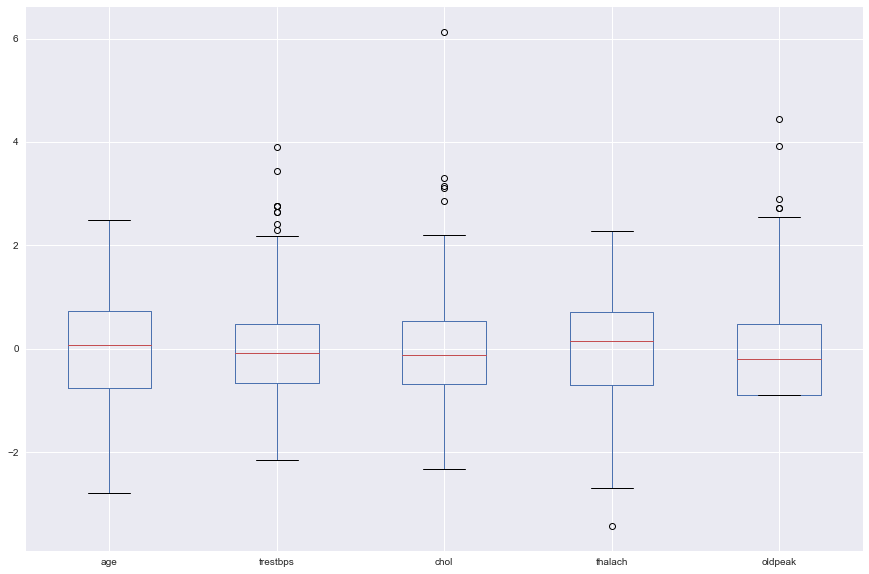

In [15]:
ax = df.plot.box(figsize=(15, 10))

In [16]:
df = pd.get_dummies(df, sparse=False, drop_first=True)

In [17]:
df.head()

,age,trestbps,chol,thalach,oldpeak,sex_1,cp_1,cp_2,cp_3,fbs_1,...,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3,target_1
0,0.950624,0.762694,-0.255910,0.015417,1.085542,1,0,0,1,1,...,0,0,0,0,0,0,1,0,0,1
1,-1.912150,-0.092585,0.072080,1.630774,2.119067,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
2,-1.471723,-0.092585,-0.815424,0.975900,0.310399,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,1
3,0.179877,-0.662770,-0.198030,1.237849,-0.206364,1,1,0,0,0,...,0,1,0,0,0,0,0,1,0,1
4,0.289984,-0.662770,2.078611,0.582975,-0.378618,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1


In [18]:
df_mix = df.sample(frac=1, random_state=3479)
df_mix.head(10)

,age,trestbps,chol,thalach,oldpeak,sex_1,cp_1,cp_2,cp_3,fbs_1,...,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3,target_1
120,1.060731,-0.092585,1.094639,-1.207015,0.827161,0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,1
288,0.289984,-1.232956,1.712033,-0.290191,1.688432,1,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
50,-0.370656,-0.092585,0.187842,-0.028241,-0.464745,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,1
125,-2.242470,-0.776808,-0.699662,1.849065,-0.292491,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,1
193,0.620304,0.762694,0.689474,-0.333849,1.516178,1,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
147,0.620304,1.047787,-0.120855,0.932241,-0.120237,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,1
228,0.510197,2.188159,0.805236,0.408342,-0.723126,1,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
127,1.391051,1.161824,0.593007,0.975900,-0.895381,0,0,1,0,0,...,0,1,1,0,0,0,0,1,0,1
29,-0.150443,-0.092585,-0.950479,0.102734,0.138144,1,0,1,0,1,...,0,0,0,0,0,0,0,1,0,1
173,0.400091,0.021453,-0.429552,1.019558,1.860686,1,0,1,0,0,...,0,1,0,1,0,0,0,0,1,0


In [19]:
df_mix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303 entries, 120 to 131
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        303 non-null    float64
 1   trestbps   303 non-null    float64
 2   chol       303 non-null    float64
 3   thalach    303 non-null    float64
 4   oldpeak    303 non-null    float64
 5   sex_1      303 non-null    uint8  
 6   cp_1       303 non-null    uint8  
 7   cp_2       303 non-null    uint8  
 8   cp_3       303 non-null    uint8  
 9   fbs_1      303 non-null    uint8  
 10  restecg_1  303 non-null    uint8  
 11  restecg_2  303 non-null    uint8  
 12  exang_1    303 non-null    uint8  
 13  slope_1    303 non-null    uint8  
 14  slope_2    303 non-null    uint8  
 15  ca_1       303 non-null    uint8  
 16  ca_2       303 non-null    uint8  
 17  ca_3       303 non-null    uint8  
 18  ca_4       303 non-null    uint8  
 19  thal_1     303 non-null    uint8  
 20  thal_2  

In [20]:
log_reg = Regressor(label='target_1', l_rate=.5, reg_rate=.5, beta=.5)

In [21]:
X_train, y_train, X_test, y_test = log_reg.split(df_mix, cutoff=.8)

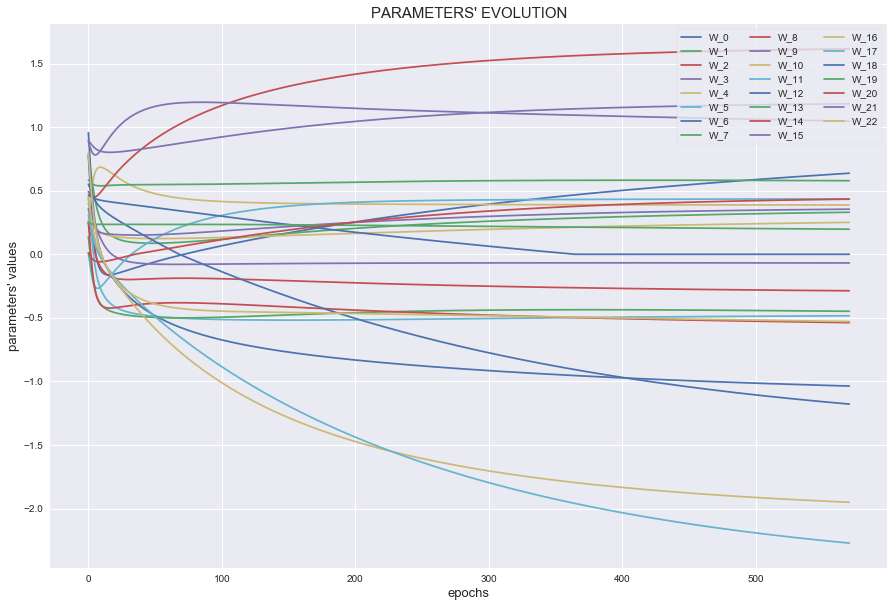

In [22]:
log_reg.fit(X_train, y_train, graph=True).predict(X_test)

In [23]:
features = np.insert(df_mix.columns.to_numpy()[:-1], 0, 'intercept')
weights = pd.DataFrame({'features' : features, 'weights': log_reg.weights.reshape(23)})
#weights = pd.DataFrame(log_reg.weights, columns=features, index=['weights'])
weights

,features,weights
0,intercept,0.637401
1,age,0.330479
2,trestbps,-0.287010
3,chol,-0.068224
4,thalach,0.387853
5,oldpeak,-0.483335
6,sex_1,-1.036023
7,cp_1,0.578609
8,cp_2,1.614972
9,cp_3,1.183125


In [24]:
log_reg.metrics(y_test)

Accuracy: 0.8688524590163934
Precision: 0.8717948717926364
Recall: 0.9189189189164353
F1 score: 0.8947368420529431

Confusion Matrix:
 [[34  5]
 [19  3]]


array([[34,  5],
       [19,  3]])

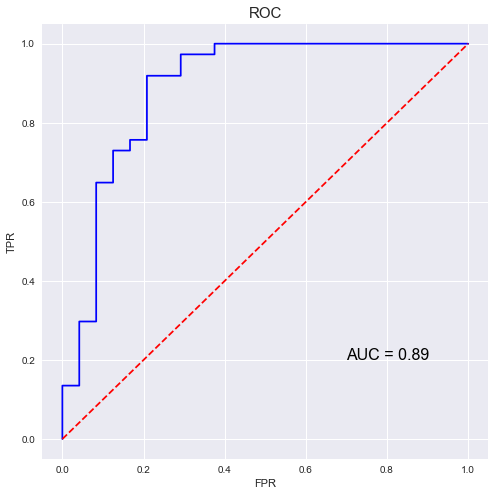

In [25]:
log_reg.ROC(y_test)

In [26]:
log_reg.cross_val(df_mix)

Accuracy: 0.8833333333333333
Precision: 0.8764705877197232
Recall: 0.9141104288870489
F1 score: 0.8948948943574206

Confusion Matrix:
 [[149  21]
 [116  14]]
